In [1]:
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import csv
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")

# Data Import

In [2]:
path = r"data\train.csv"
df = pd.read_csv(path, encoding = "ISO-8859-1")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Apply pre-processing as indicated in Exploratory_Data_Analysis notebook.

In [3]:
df["Postal Code"] = df["Postal Code"].fillna(5401)
df["Order Date"] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df["Ship Date"] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')
df_changed = df.drop(columns=["Row ID", "Country"])


# Time Series Analysis
Okay. So now let's finally analyse the time series data further. Let's see if there are any time related patterns in the data where we could learn something from!

In [4]:
df_datetime = df_changed.set_index("Order Date")
df_datetime.head()

,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,
2017-11-08,CA-2017-152156,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2017-11-08,CA-2017-152156,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2017-06-12,CA-2017-138688,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
2016-10-11,US-2016-108966,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
2016-10-11,US-2016-108966,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


As a first step, the sales are plotted against the Order Date. This should help to gain some insights whether the sales are having some seasonal components or not.

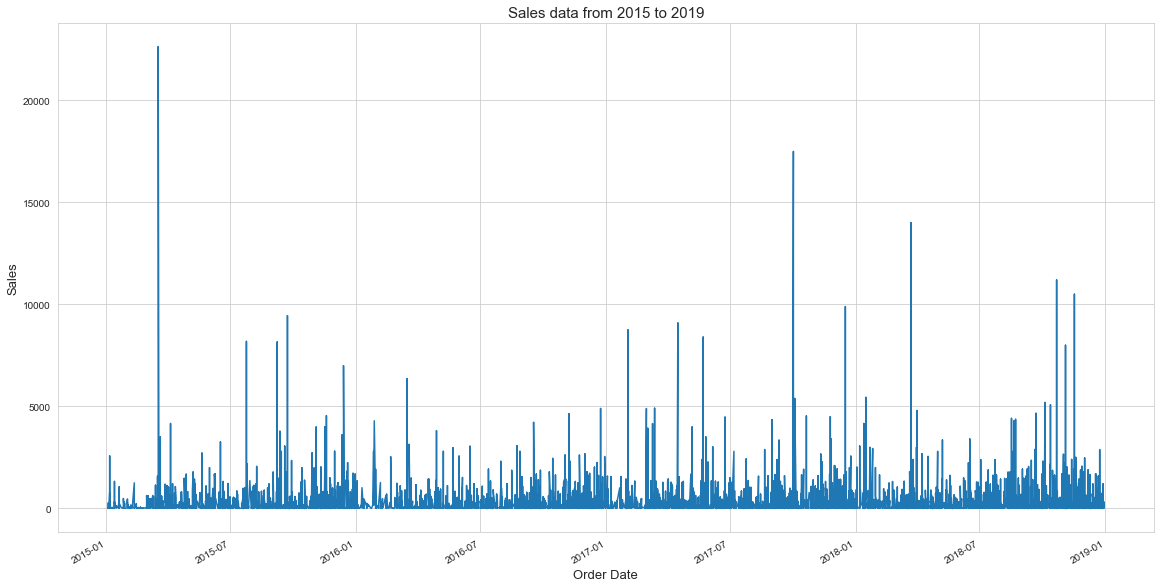

In [5]:
plt.figure(figsize=(16, 8))
df_datetime["Sales"].plot()
plt.tight_layout()
plt.title("Sales data from 2015 to 2019", size=15)
plt.ylabel("Sales", size=13)
plt.xlabel("Order Date", size=13)
plt.savefig(r"figures\sales_full_time.pdf")
plt.show()

Let's check the frequency of our data. We want to have daily sales data and only one value per day!

In [6]:
print('\nUnique dates in our data: ', len(df_datetime.index.unique()), 'Days')
our_date_range = df_datetime.index.max() - df_datetime.index.min()

# Calculate number of days in date range
print('Total days in our date range:', our_date_range.days, 'Days')


Unique dates in our data:  1230 Days
Total days in our date range: 1457 Days


In [7]:
# create daily data and replace NaN values, caused by missing days, with the linear interpolation of the days around
weekly_sales = pd.DataFrame(df_datetime["Sales"].resample('D').mean()).interpolate(method='linear')
weekly_sales.head(10)

,Sales
Order Date,
2015-01-03,16.448000
2015-01-04,96.020000
2015-01-05,19.536000
2015-01-06,489.677778
2015-01-07,43.579000
2015-01-08,31.925500
2015-01-09,20.272000
2015-01-10,27.415000
2015-01-11,9.940000


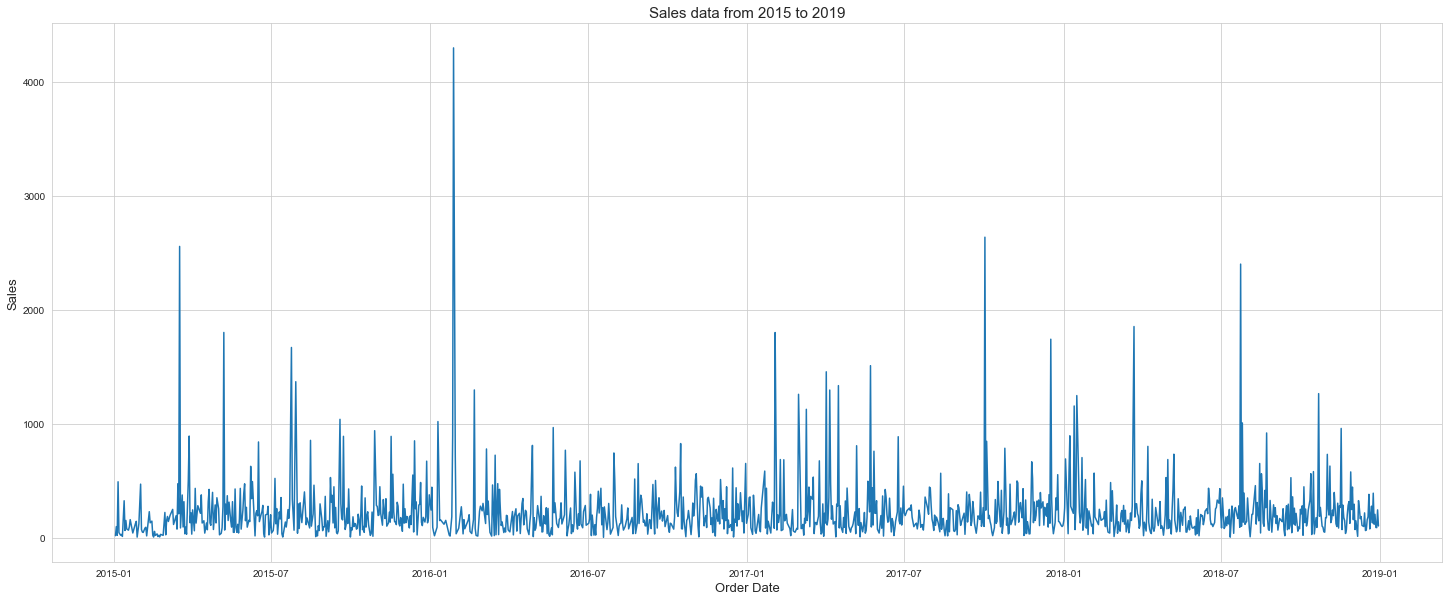

In [8]:
fig = plt.figure(figsize=(20, 8))
plt.plot(weekly_sales.index, weekly_sales["Sales"])
plt.tight_layout()
plt.title("Sales data from 2015 to 2019", size=15)
plt.ylabel("Sales", size=13)
plt.xlabel("Order Date", size=13)
plt.savefig(r"figures\daily_sales_full_time.pdf")
plt.show()

Looks way better now. Let's reduce the timeframe to only display the yearly sales data.

<ipython-input-9-0f69b3a28026>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(weekly_sales[year].index, weekly_sales[year]["Sales"])
<ipython-input-9-0f69b3a28026>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(weekly_sales[year].index, weekly_sales[year]["Sales"])
<ipython-input-9-0f69b3a28026>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(weekly_sales[year].index, weekly_sales[year]["Sales"])
<ipython-input-9-0f69b3a28026>:5: FutureWarning: Indexing a D

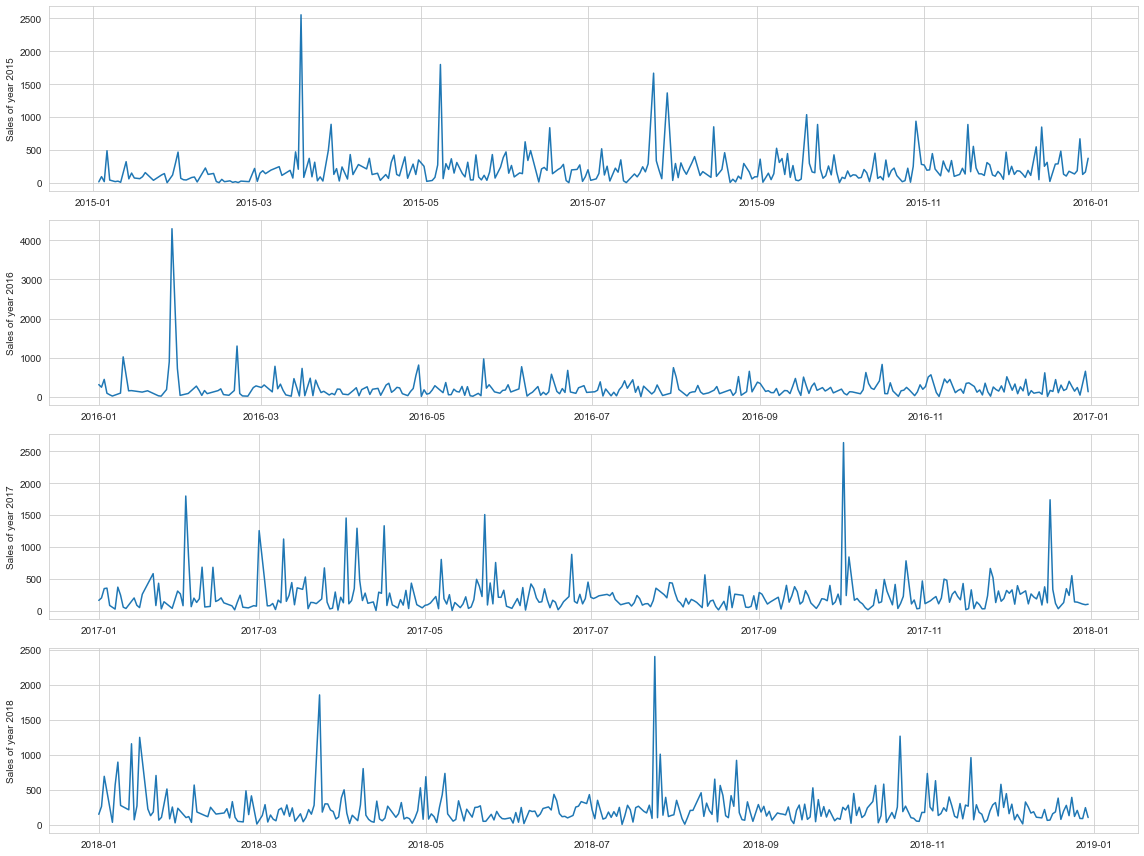

In [9]:
fig = plt.figure(figsize = (16, 12))
years = ["2015", "2016", "2017", "2018"]
for idx, year in enumerate(years):
    plt.subplot(len(years), 1, idx+1)
    plt.plot(weekly_sales[year].index, weekly_sales[year]["Sales"])
    plt.ylabel(f"Sales of year {year}")
plt.tight_layout()
plt.savefig(r"figures\yearly_sales_data_subplot.pdf")
plt.show()